In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from datetime import datetime, date
from scipy.stats import linregress
import scipy.signal as signal
from matplotlib import cm
import xarray as xr
import cartopy.crs as ccrs
from pyproj import Transformer 
from scipy.interpolate import griddata
import cmocean.cm as cmo
from matplotlib import ticker
from scipy.stats import binned_statistic_2d
import matplotlib.path as mpath
from scipy.stats import gaussian_kde
import calctsi as ct
import matplotlib.dates as mdates

In [16]:
#define filepaths

outfp = '/data/users/janheuser/images/'
tsifp = '/ships19/cryo/janheuser/tsi/'
buoyfn = '/home/janheuser/projects/thk/SLICE_paperrevs/release/SLICE_1D.nc'
dhdtfn = '/home/janheuser/projects/thk/SLICE_paperrevs/release/SLICE_dhdt.nc'
oibfp = '/ships19/cryo/janheuser/oib/'
bwfp='/home/janheuser/projects/thk/SLICE_paperrevs/release_2/SLICE_basinwide/'
csfp = '/ships19/cryo/janheuser/cs2smos/ftp.awi.de/sea_ice/product/cryosat2_smos/v203/nh/'
piofp = '/ships19/cryo/janheuser/piomas/'
kfp = '/ships19/cryo/janheuser/DATA/Arctic_Ocean/'

In [3]:
#define some global parameters

fs=28
lw=8
plt.rcParams['font.size']=fs

proj=ccrs.Stereographic(central_longitude=0, central_latitude=90)

transformer = Transformer.from_crs(4326, 6931)

ease=xr.open_dataset('../../EASE2_N25km.geolocation.v0.9.nc')
ease['y']=-ease.y
y_bins=0.5*ease.y.values[:-1]+0.5*ease.y.values[1:]
y_bins=np.concatenate([[y_bins[0]-np.diff(y_bins)[0]],y_bins,[y_bins[-1]+np.diff(y_bins)[0]]])

x_bins=0.5*ease.x.values[:-1]+0.5*ease.x.values[1:]
x_bins=np.concatenate([[x_bins[0]-np.diff(x_bins)[0]],x_bins,[x_bins[-1]+np.diff(x_bins)[0]]])

/home/janheuser/.conda/envs/thk/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/janheuser/.conda/envs/thk/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/janheuser/.conda/envs/thk/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


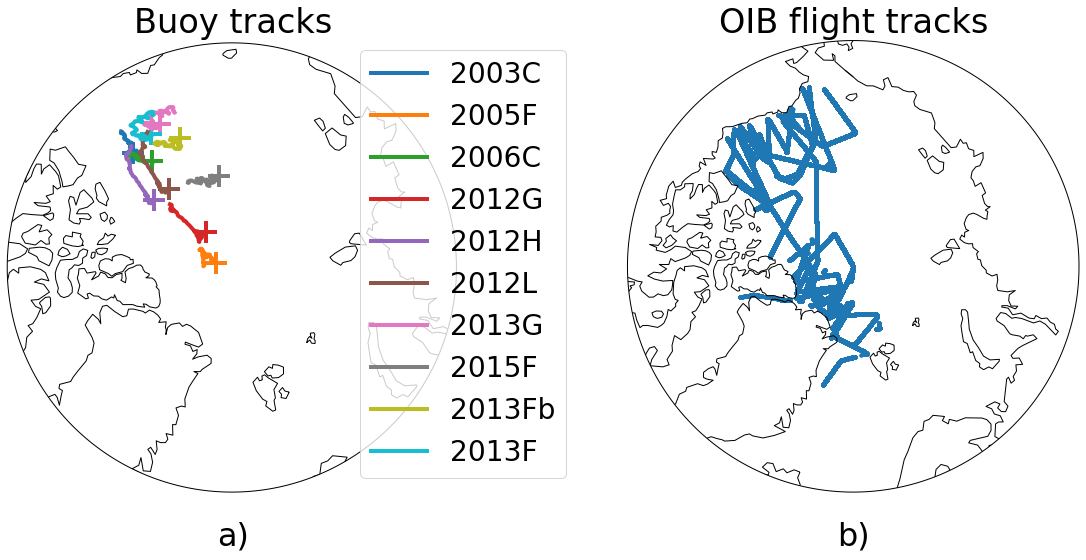

In [4]:
#figure 1

alldata=xr.open_dataset(buoyfn)

ave=100

f, ax = plt.subplots(1, 2, subplot_kw={'projection': proj})
ax=ax.ravel()
f.set_figheight(8)
f.set_figwidth(16)
ax[0].set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree())
r_limit = ax[0].get_ylim()
ax[0].set_xlim(1.0001*np.array(r_limit))
ax[0].set_ylim(1.0001*np.array(r_limit))
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit[0],
                           circle_path.codes.copy())
ax[0].set_boundary(circle_path)
ax[0].set_frame_on(False) 
ax[0].coastlines()
ax[0].text(0.5, -0.1, "a)", transform=ax[0].transAxes, fontsize=32, va='center', ha='center')

for b in alldata.buoy:
    data=alldata.sel(buoy=b)
    if b == '2003C':
        data['Longitude'][150]=np.nan
    data=data.dropna(dim='index').swap_dims({'index':'Date'})
    data=data.sel(Date=slice(date(int(data.Date.dt.year[0].values),11,1), date(int(data.Date.dt.year[0].values)+1,4,1)))
    ax[0].plot(data.Longitude.values, data.Latitude.values, transform=ccrs.PlateCarree(), label=b.values, linewidth=4)
    ax[0].scatter(data.Longitude[0], data.Latitude[0], s=500, transform=ccrs.PlateCarree(), marker='+',linewidth=4)
    
ax[0].legend(loc="lower left", bbox_to_anchor=(0.75, 0))
ax[0].set_title('Buoy tracks')

ax[1].set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
r_limit = ax[1].get_ylim()
ax[1].set_xlim(1.0001*np.array(r_limit))
ax[1].set_ylim(1.0001*np.array(r_limit))
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit[0],
                           circle_path.codes.copy())
ax[1].set_boundary(circle_path)
ax[1].set_frame_on(False) 
ax[1].coastlines()

for yr in [2013,2014,2015,2016,2017,2018,2019]:

    fn=glob.glob(oibfp + '*' +str(yr)+'03*.txt')
    
    for i in range(0,len(fn)):
        #open ice bridge data
        oib=pd.read_csv(fn[i],index_col=False)
        oib=oib.where(oib.thickness!=-99999).where(oib.thickness_unc<1.3)
        if len(oib.thickness.dropna().values)==0:
            continue

        #transform oib data to ease coordinates
        transformer=Transformer.from_crs(4326,6931)
        oibx,oiby=transformer.transform(oib.lat.dropna().values,oib.lon.dropna().values)

        plt.scatter(oibx, oiby,color=plt.cm.tab10(0),s=10,label=yr)

ax[1].set_title('OIB flight tracks')        
ax[1].text(0.5, -0.1, "b)", transform=ax[1].transAxes, fontsize=32, va='center', ha='center')
    
f.tight_layout()

plt.savefig(outfp + 'path.png')



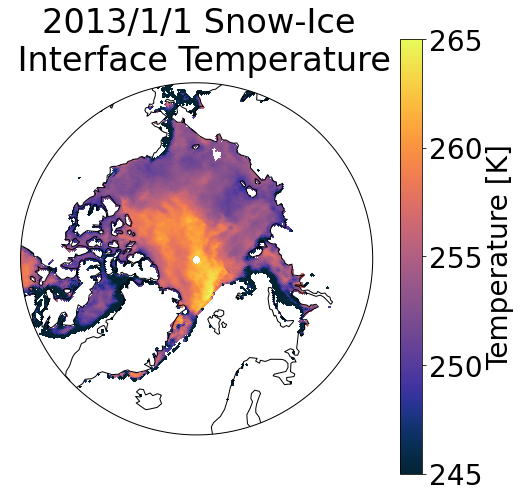

In [5]:
#Figure 2

tsi=ct.calcTsi_amsr(date(2013, 1, 1))

f, ax = plt.subplots(1, 1, subplot_kw={'projection': proj})
f.set_figheight(8)
f.set_figwidth(8)

d = ax.pcolormesh(tsi.lon.values, tsi.lat.values, tsi.dat.values, cmap=cmo.thermal, transform=ccrs.PlateCarree(),
                 vmin=245, vmax=265)
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
r_limit = ax.get_ylim()
ax.set_xlim(1.0001*np.array(r_limit))
ax.set_ylim(1.0001*np.array(r_limit))
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit[0],
                           circle_path.codes.copy())
ax.set_boundary(circle_path)
ax.set_frame_on(False) 
d = ax.pcolormesh(tsi.lon.values, tsi.lat.values, tsi.dat.values, cmap=cmo.thermal, transform=ccrs.PlateCarree(),
                 vmin=245, vmax=265)
ax.coastlines()
ax.set_title('2013/1/1 Snow-Ice\n Interface Temperature')
cb = plt.colorbar(d)
cb.set_label('Temperature [K]')

plt.savefig(outfp + 'tsi.png')

plt.show()

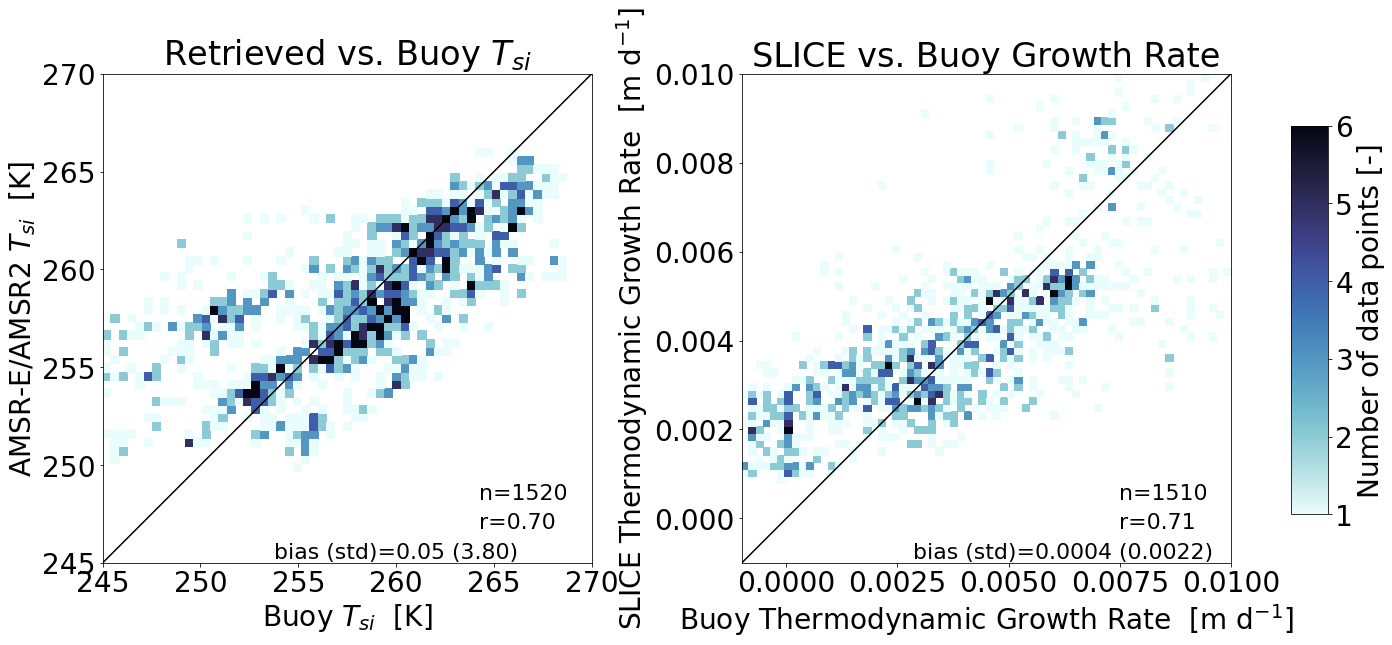

In [6]:
#Figure 3

ave=14
alldata=xr.open_dataset(dhdtfn)

f, ax = plt.subplots(1,2,figsize=(21, 9),facecolor='white')
ax=ax.ravel()

inds=~np.isnan(alldata['atsi'].values.ravel())*~np.isnan(alldata['0.0'].values.ravel())
ax[0].hist2d(alldata['0.0'].values.ravel()+273, alldata['atsi'].values.ravel(), 
             np.linspace(245,270,60), cmap=cmo.ice_r, cmin=0.5,vmin=1, vmax=6)
ax[0].plot(range(240,274),range(240,274),'k')
ax[0].set_xlim((245,270))
ax[0].set_ylim((245,270))
ax[0].set(aspect='equal')
ax[0].set_title('Retrieved vs. Buoy $T_{si}$')
ax[0].set_xlabel('Buoy $T_{si}$  [K]')
ax[0].set_ylabel('AMSR-E/AMSR2 $T_{si}$  [K]')
n=len(inds)
r=linregress(alldata['atsi'].values.ravel()[inds], alldata['0.0'].values.ravel()[inds]+273)
b=(alldata['atsi'].values.ravel()[inds]-alldata['0.0'].values.ravel()[inds]-273).mean()
s=(alldata['atsi'].values.ravel()[inds]-alldata['0.0'].values.ravel()[inds]-273).std()
ax[0].text(0.77, 0.13, 'n=' + str(n),transform=ax[0].transAxes, fontsize=22)
ax[0].text(0.35, 0.01, 'bias (std)=' + "{:.2f}".format(b) + ' (' + "{:.2f}".format(s) + ')' ,transform=ax[0].transAxes, fontsize=22)
ax[0].text(0.77, 0.07, 'r=' + "{:.2f}".format(r.rvalue) ,transform=ax[0].transAxes, fontsize=22)


# inds=~np.isnan(alldata['H_predicted_2'].diff('index').rolling(index=1,center=True).mean()/alldata['Date'].diff('index').dt.days.values).values.ravel()*~np.isnan(alldata['Ice Thickness'].diff('index').rolling(index=ave,center=True).mean()/alldata['Date'].diff('index').dt.days.values).values.ravel()
# d=ax[1].hist2d((alldata['Ice Thickness'].diff('index').rolling(index=ave,center=True).mean().values.ravel()/alldata['Date'].diff('index').dt.days.values.ravel()),
#                ((alldata['H_predicted_2'][:,1:].values.ravel()-alldata['Ice Thickness'][:,:-1].values.ravel())/alldata['Date'].diff('index').dt.days.values.ravel()),
#                bins=np.linspace(-0.001,0.015,100),cmap=cmo.ice_r,cmin=0.5, vmin=1,vmax=6)
inds=~np.isnan(alldata['dhdt'][:,1:]/alldata['Date'].diff('index').dt.days.values).values.ravel()*~np.isnan(alldata['Ice Thickness'].diff('index').rolling(index=ave,center=True).mean()/alldata['Date'].diff('index').dt.days.values).values.ravel()
d=ax[1].hist2d((alldata['Ice Thickness'].diff('index').rolling(index=ave,center=True).mean().values.ravel()/alldata['Date'].diff('index').dt.days.values.ravel()),
               (alldata['dhdt'][:,1:]/alldata['Date'].diff('index').dt.days.values).values.ravel(),
               bins=np.linspace(-0.001,0.015,100),cmap=cmo.ice_r,cmin=0.5, vmin=1,vmax=6)
# d=ax[1].scatter((alldata['Ice Thickness'].diff('index').rolling(index=ave,center=True).mean().values.ravel()/alldata['Date'].diff('index').dt.days.values.ravel()),
#                ((alldata['dhdt'][:,1:])/alldata['Date'].diff('index').dt.days.values).values.ravel(),c=alldata['Ice Thickness'][:,1:].rolling(index=ave,center=True).mean().values.ravel(),cmap=cmo.ice_r)
ax[1].plot((-0.002,0.03),(-0.002,0.03),'k')
ax[1].set_xlim((-0.001,0.01))
ax[1].set_ylim((-0.001,0.01))
ax[1].set(aspect='equal')
ax[1].set_title('SLICE vs. Buoy Growth Rate')
ax[1].set_xlabel('Buoy Thermodynamic Growth Rate  [m d$^{-1}$]')
ax[1].set_ylabel('SLICE Thermodynamic Growth Rate  [m d$^{-1}$]')
n=len(inds)
r=linregress(((alldata['dhdt'][:,1:])/alldata['Date'].diff('index').dt.days.values).values.ravel()[inds], (alldata['Ice Thickness'].diff('index').rolling(index=ave,center=True).mean()/alldata['Date'].diff('index').dt.days.values).values.ravel()[inds])
b=((alldata['dhdt'][:,1:]/alldata['Date'].diff('index').dt.days.values).values.ravel()[inds]-(alldata['Ice Thickness'].diff('index').rolling(index=ave,center=True).mean()/alldata['Date'].diff('index').dt.days.values).values.ravel()[inds]).mean()
s=((alldata['dhdt'][:,1:]/alldata['Date'].diff('index').dt.days.values).values.ravel()[inds]-(alldata['Ice Thickness'].diff('index').rolling(index=ave,center=True).mean()/alldata['Date'].diff('index').dt.days.values).values.ravel()[inds]).std()
ax[1].text(0.77, 0.13, 'n=' + str(n),transform=ax[1].transAxes, fontsize=22)
ax[1].text(0.35, 0.01, 'bias (std)=' + "{:.4f}".format(b) + ' (' + "{:.4f}".format(s) + ')' ,transform=ax[1].transAxes, fontsize=22)
ax[1].text(0.77, 0.07, 'r=' + "{:.2f}".format(r.rvalue) ,transform=ax[1].transAxes, fontsize=22)


cbar_ax = f.add_axes([0.925, 0.2, 0.025, 0.6])
cb=f.colorbar(d[3],cax=cbar_ax, label='Number of data points [-]')

plt.savefig(outfp + 'tsi_dhdt_val', bbox_inches="tight")



median buoy thickness linear correlation: 0.9915586191543286
mean (std) buoy thickness linear correlation: 0.8827877399901334 (0.21067214575367682)
mean (std) buoy thickness linear correlation without 2012L or 2013G: 0.9850248901661716 (0.02507604657947706)
mean (std) buoy thickness bias: 0.07841054666533773 (0.06845749723165508)


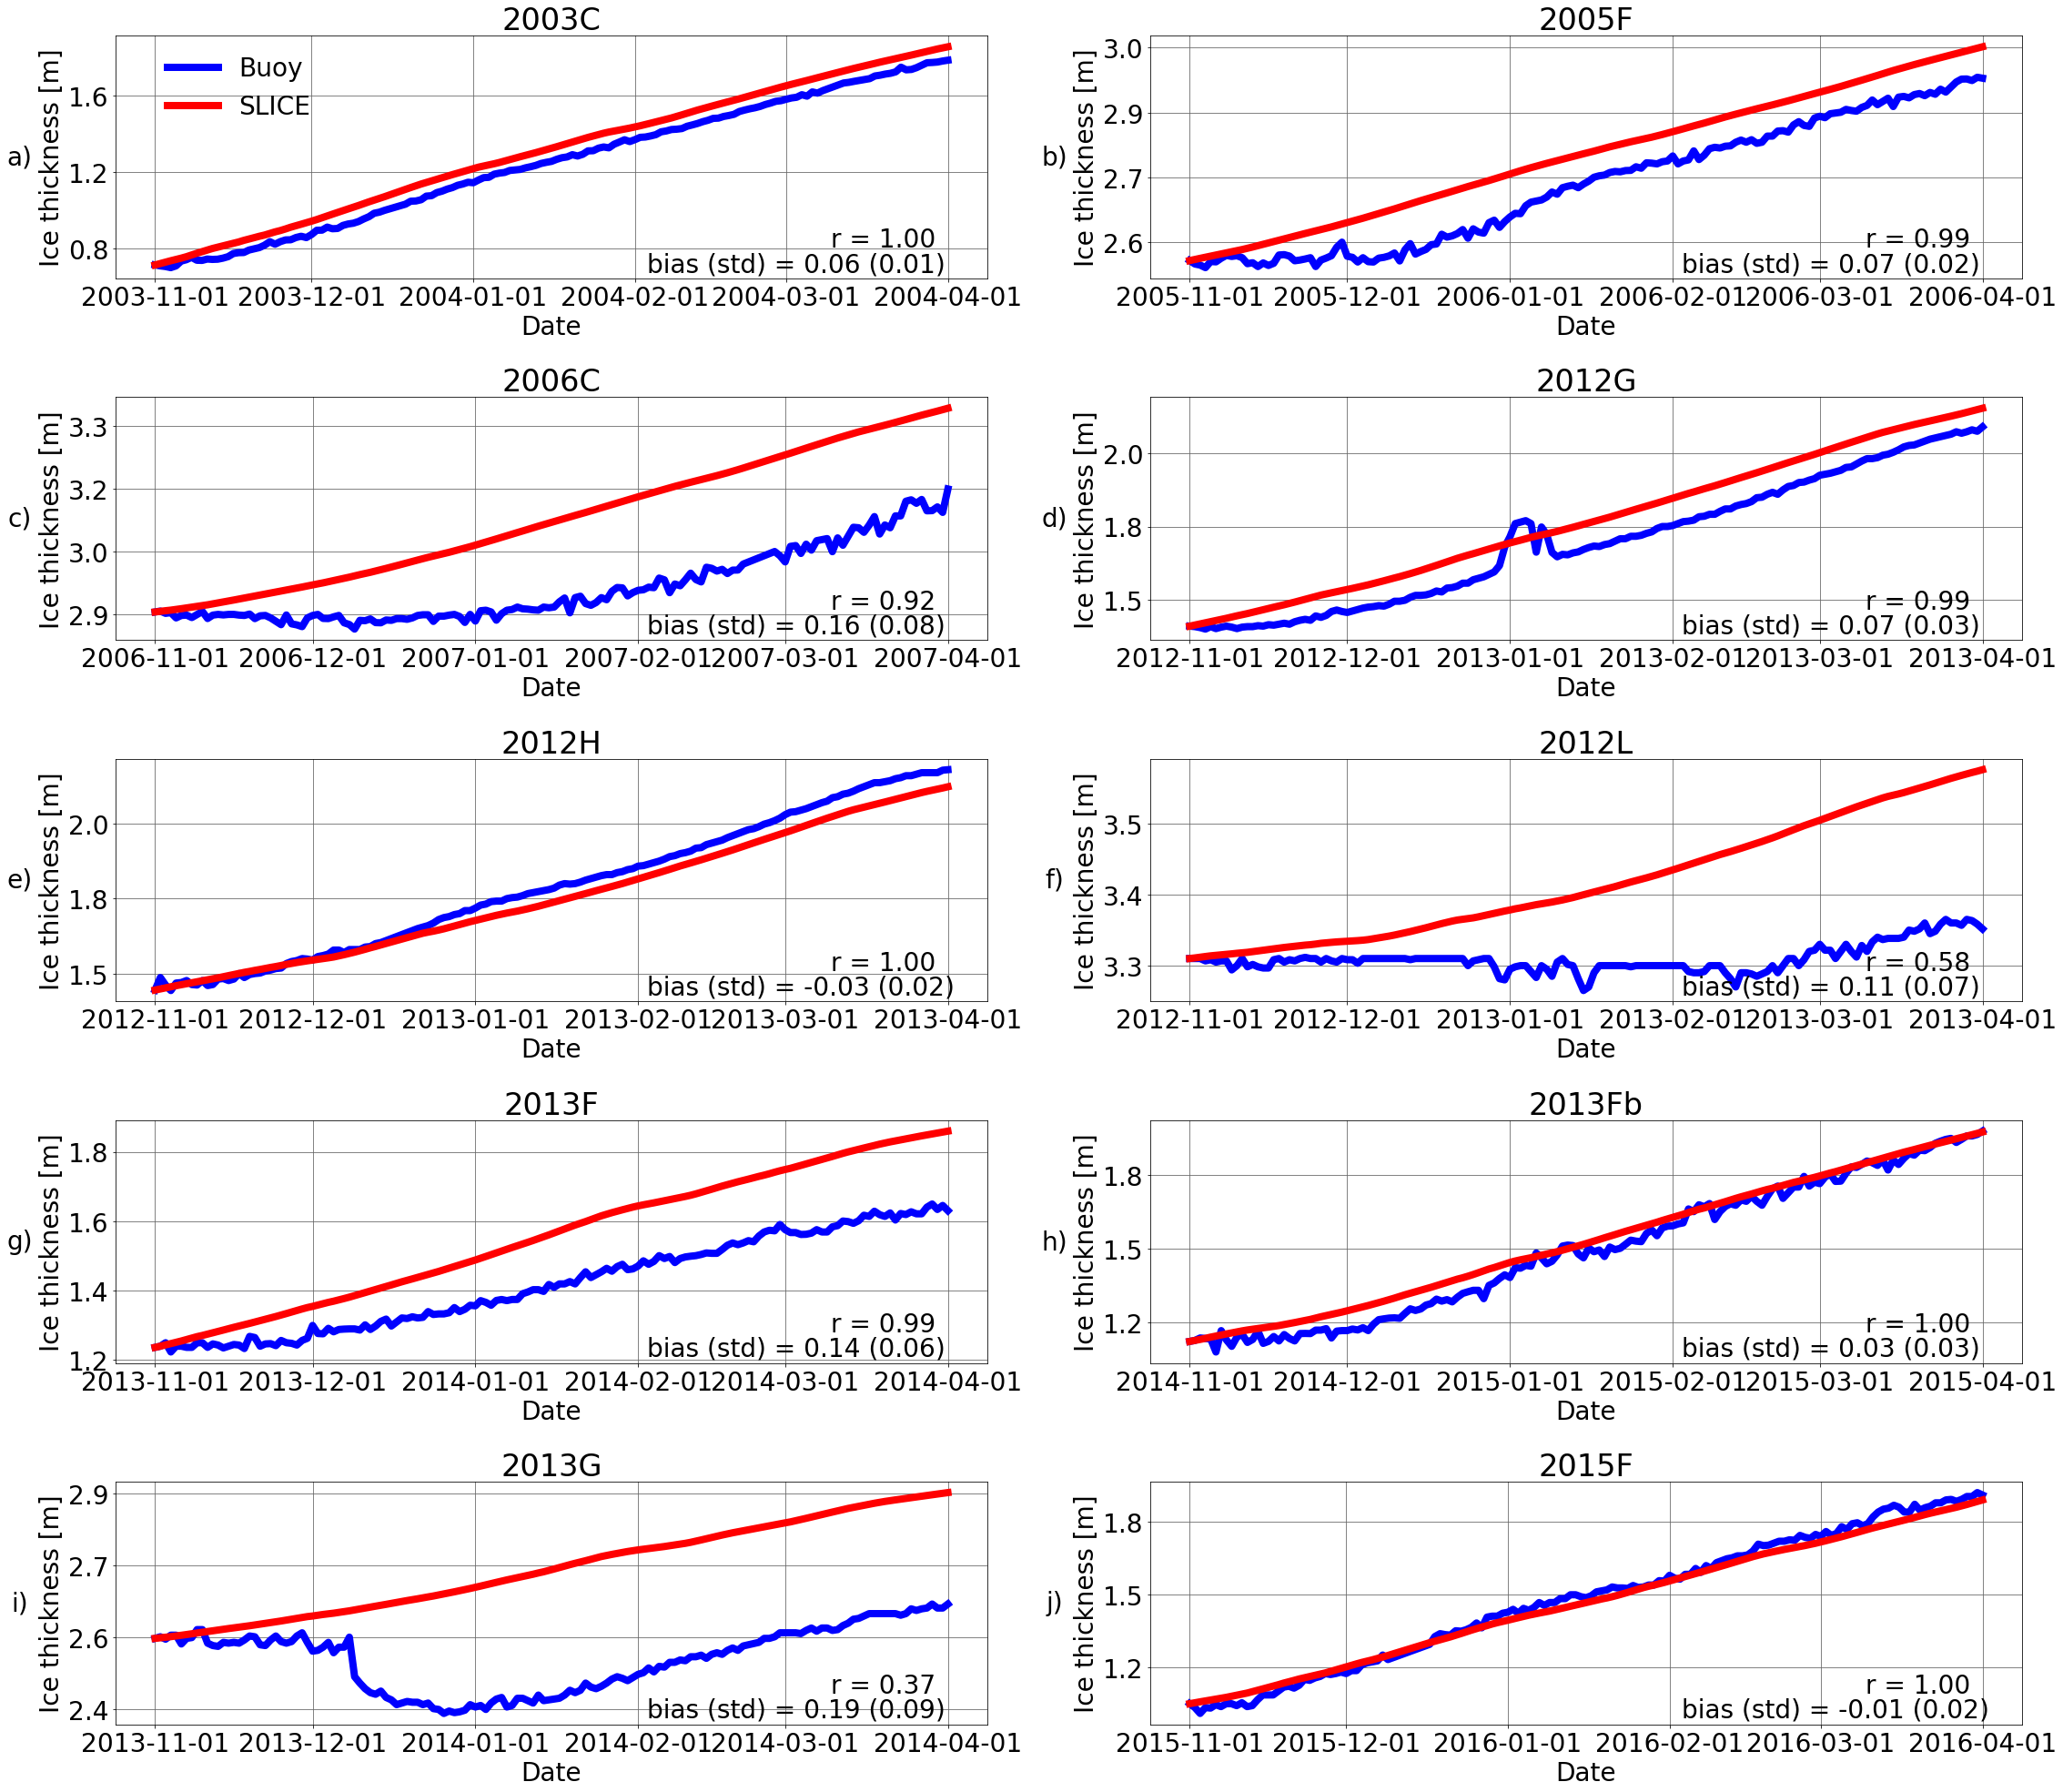

In [7]:
#Figure 4

alldata=xr.open_dataset(buoyfn)


r=[]
b=[]

labels=['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']

f, ax = plt.subplots(5,2)
ax=ax.ravel()
f.set_figheight(28)
f.set_figwidth(32)

buoys=alldata.buoy
buoys=buoys.sortby(buoys)

for i in range(0,len(buoys)): 
    data=alldata.sel(buoy=buoys[i])
    ax[i].plot(data.Date,data['Ice Thickness'].values,'b',label='Buoy',linewidth=lw)
    ax[i].plot(data.Date,data['H_predicted_2'].values,label='SLICE',color='red',linestyle='-',linewidth=lw)
    
    inds=~np.isnan(data['Ice Thickness'].values)*~np.isnan(data['H_predicted_2'].values)
    res=linregress(data['Ice Thickness'].values[inds], data['H_predicted_2'].values[inds])
    r.append(res.rvalue)
    
    bias=(data['H_predicted_2']-data['Ice Thickness']).mean(dim='index').values
    std=(data['H_predicted_2']-data['Ice Thickness']).std(dim='index').values
    b.append(bias)    
    
    ax[i].text(0.61, 0.03, 'bias (std) = ' + "{:.2f}".format(bias) + ' (' + "{:.2f}".format(std) + ')' ,transform=ax[i].transAxes, fontsize=fs)
    ax[i].text(0.82, 0.13, 'r = ' + "{:.2f}".format(res.rvalue) ,transform=ax[i].transAxes, fontsize=fs)
    
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel('Ice thickness [m]')
    ax[i].set_title(str(buoys[i].values))
    ax[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax[i].yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].grid(b=True, which='major', color='#666666', linestyle='-')
    ax[i].text(-0.11, 0.5, labels[i], transform=ax[i].transAxes, va='center', ha='center')

    if buoys[i]=='2003C':
        ax[i].legend(loc='lower right', bbox_to_anchor=(0.25,.56), frameon=False)
#     ax[i].set_ylim((data['H_predicted_2'].mean()-1,data['H_predicted_2'].mean()+1))
    
f.tight_layout()

plt.savefig(outfp + 'thermo_buoys.png', bbox_inches="tight")

print('median buoy thickness linear correlation: ' + str(np.median(np.array(r))))
print('mean (std) buoy thickness linear correlation: ' + str(np.array(r).mean()) + ' (' + str(np.array(r).std()) + ')')
print('mean (std) buoy thickness linear correlation without 2012L or 2013G: ' + str(np.sort(np.array(r))[2:].mean()) + ' (' + str(np.sort(np.array(r))[2:].std()) + ')')
print('mean (std) buoy thickness bias: ' + str(np.array(b).mean()) + ' (' + str(np.array(b).std()) + ')')

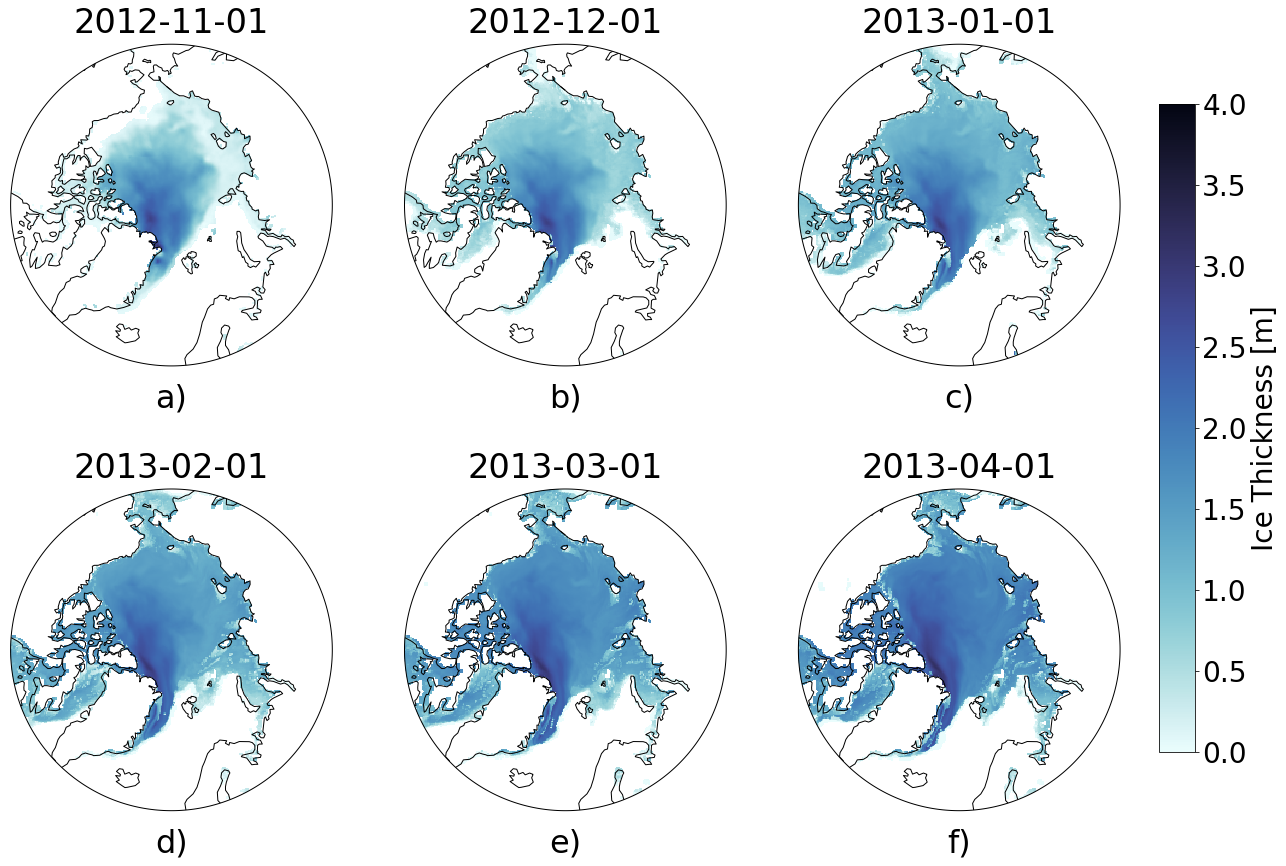

In [8]:
#Figure 5

labels=['a)','b)','c)','d)','e)','f)']

yr=2012

bw=xr.open_dataset(bwfp + str(yr) + '_slice_basinwide.nc')

days=[str(yr) + '-11-01', str(yr) + '-12-01', str(yr+1) + '-01-01', str(yr+1) + '-02-01', str(yr+1) + '-03-01', str(yr+1) + '-04-01']

proj=ccrs.Stereographic(central_longitude=0, central_latitude=90)
f, ax=plt.subplots(2,3, subplot_kw={'projection': proj})
ax=ax.ravel()
f.set_figheight(15)
f.set_figwidth(20)

for i in range(0,6):    
    bwi=bw.sea_ice_thickness.sel(time=days[i])
    
    ax[i].set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    r_limit = ax[i].get_ylim()
    circle_path = mpath.Path.unit_circle()
    circle_path = mpath.Path(circle_path.vertices.copy() * r_limit[0], circle_path.codes.copy())
    ax[i].set_boundary(circle_path)
    ax[i].set_frame_on(False) 
    d = ax[i].pcolormesh(bwi.x.values, bwi.y.values, bwi[0,:,:].values, cmap=cmo.ice_r,vmin=0,vmax=4)
    ax[i].coastlines()
    ax[i].set_title(days[i])
    
    ax[i].text(0.5, -0.1, labels[i], transform=ax[i].transAxes, fontsize=32, va='center', ha='center')
    
cbar_ax = f.add_axes([0.925, 0.2, 0.025, 0.6])
cb=f.colorbar(d, cax=cbar_ax)
cb.set_label('Ice Thickness [m]')   
plt.savefig(outfp + 'monthly.png', bbox_inches="tight")


/home/janheuser/.conda/envs/thk/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/janheuser/.conda/envs/thk/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/janheuser/.conda/envs/thk/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


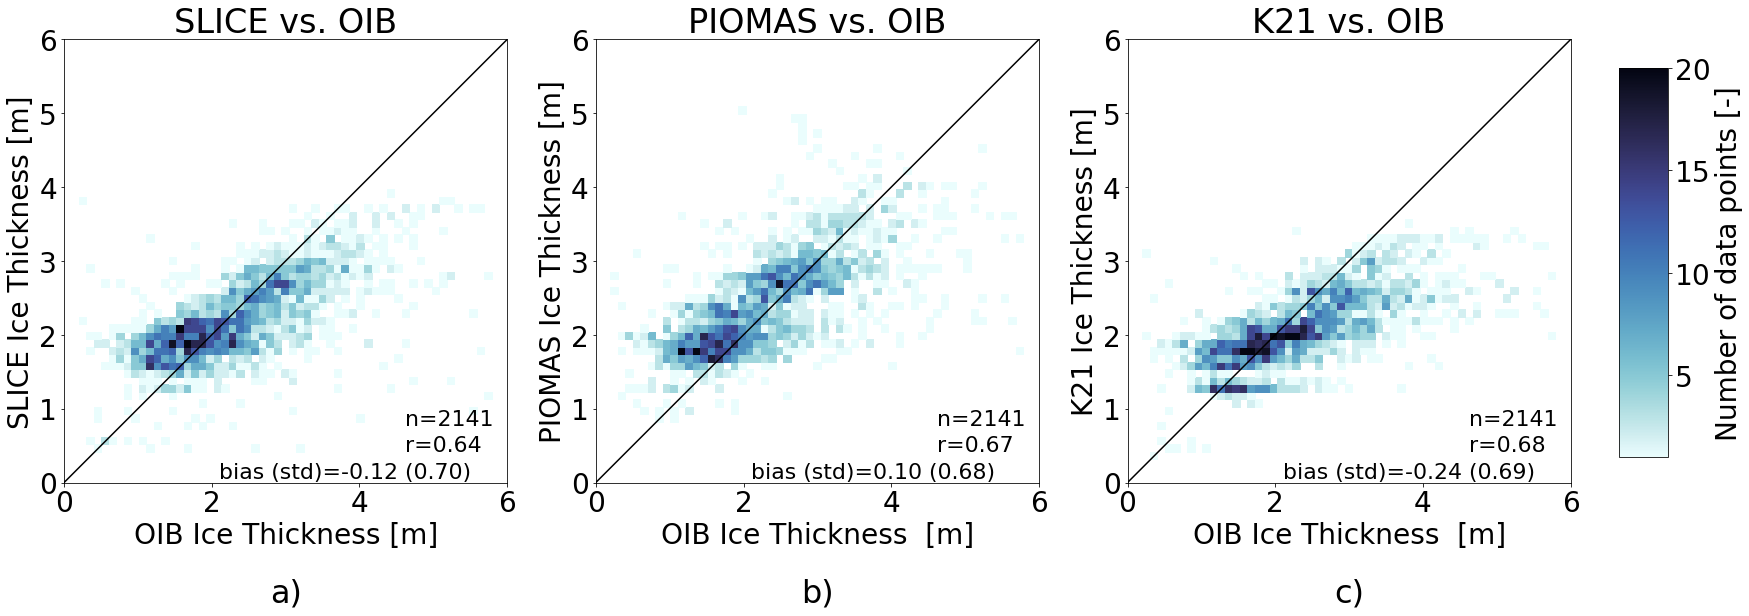

In [9]:
#Figure 6

slclist=np.array([])
piolist=np.array([])
oiblist=np.array([])
klist=np.array([])

ave=1

grid = np.genfromtxt(piofp + '/grid.dat')
grid = np.reshape(grid,(grid.size))
plon = grid[:grid.size//2]   
plat = grid[grid.size//2:]

piox, pioy = transformer.transform(plat, plon)

klat=np.fromfile(kfp + 'psn_lat_25km_304x448.dat',dtype=np.float32).reshape(304,448)
klon=np.fromfile(kfp + 'psn_lon_25km_304x448.dat',dtype=np.float32).reshape(304,448)
kx, ky = transformer.transform(klat.ravel(), klon.ravel())

for yr in [2013,2014,2015,2016,2017,2018,2019]:

    fn=glob.glob(oibfp + '*' +str(yr)+'03*.txt')

    for i in range(0,len(fn)):
        dtind=fn[i].find(str(yr))

        #open SLICE data
        slc = xr.open_dataset(bwfp + str(yr-1) + '_slice_basinwide.nc')
        slc = slc.sea_ice_thickness.sel(time=fn[i][dtind:dtind+4]+'-'+fn[i][dtind+4:dtind+6]+'-'+fn[i][dtind+6:dtind+8])
        slc = slc.where(slc>0)

        #open piomas data and get ease coordinates
        data = np.fromfile(piofp + 'hiday.H' + str(yr), dtype='float32').reshape((365,43200))
        
        #interpolate piomas to slice grid
        pio= xr.DataArray(
            griddata((pioy, piox), np.squeeze(data[slc.time.dt.dayofyear-1, :]), (ease.y.values[:,None], ease.x.values[None,:]), 
                     method='linear'), coords=[ease.y.values, ease.x.values], 
            dims=["y", "x"])
        pio = pio.where(pio>0)

        #open ice bridge data
        oib=pd.read_csv(fn[i],index_col=False)
        oib=oib.where(oib.thickness!=-99999).where(oib.thickness_unc<1.3)
        if len(oib.thickness.dropna().values)==0:
            continue
        
        #transform oib data to ease coordinates
        oibx,oiby=transformer.transform(oib.lat.dropna().values,oib.lon.dropna().values)
        
        #bin oib data by slice grid
        oib_bins = binned_statistic_2d(oiby, oibx, oib.thickness.dropna().values, 'mean', bins=[y_bins, x_bins]).statistic
        oib_bins = xr.DataArray(oib_bins,coords=[ease.y.values, ease.x.values],dims=['y','x'])
        oib_counts = binned_statistic_2d(oiby, oibx, oib.thickness.dropna().values, 'count', bins=[y_bins, x_bins]).statistic
        oib_counts = xr.DataArray(oib_counts,coords=[ease.y.values, ease.x.values],dims=['y','x'])

        #open Kang data and interpolate to ease coordinates
        k=np.fromfile(kfp+str(yr-1)+'-'+str(yr)+'/'+fn[i][dtind:dtind+8]+'_Ice.dat',dtype=np.float32).reshape(304,448)
        k= xr.DataArray(
            griddata((ky, kx), k.ravel(), (ease.y.values[:,None], ease.x.values[None,:]), method='linear'), coords=[ease.y.values, ease.x.values], 
            dims=["y", "x"])
        k = k.where(k>0)
        
        ind=~np.isnan(slc.where(oib_counts>ave).values.ravel()*oib_bins.where(oib_counts>ave).values.ravel()*k.where(oib_counts>ave).values.ravel())
        if np.sum(ind)==0:
            continue
        piolist=np.append(piolist,pio.where(oib_counts>ave).values.ravel()[ind])
        slclist=np.append(slclist,slc.where(oib_counts>ave).values.ravel()[ind])
        oiblist=np.append(oiblist,oib_bins.where(oib_counts>ave).values.ravel()[ind])
        klist=np.append(klist,k.where(oib_counts>ave).values.ravel()[ind])
        
n=len(slclist)
        
f, ax = plt.subplots(1,3,figsize=(27, 9))
ax = ax.ravel()

# xy = np.vstack([slclist,oiblist])
# z = gaussian_kde(xy)(xy)
# idx = z.argsort()
ax[0].hist2d(oiblist,slclist,bins=np.linspace(0,6,60),cmap=cmo.ice_r,cmin=0.5, vmin=1,vmax=20)
ax[0].set_xlim((0,6))
ax[0].set_ylim((0,6))
ax[0].plot((0,7),(0,7),'k')
ax[0].set(aspect='equal')
ax[0].set_title('SLICE vs. OIB')
ax[0].set_xlabel('OIB Ice Thickness [m]')
ax[0].set_ylabel('SLICE Ice Thickness [m]')
r=linregress(slclist,oiblist)
b=np.mean(slclist-oiblist)
s=np.std(slclist-oiblist)
ax[0].text(0.77, 0.13, 'n=' + str(n),transform=ax[0].transAxes, fontsize=22)
ax[0].text(0.35, 0.01, 'bias (std)=' + "{:.2f}".format(b) + ' (' + "{:.2f}".format(s) + ')' ,transform=ax[0].transAxes, fontsize=22)
ax[0].text(0.77, 0.07, 'r=' + "{:.2f}".format(r.rvalue) ,transform=ax[0].transAxes, fontsize=22)
ax[0].text(0.5, -0.25, 'a)', transform=ax[0].transAxes, fontsize=32, va='center', ha='center')


# xy = np.vstack([piolist,oiblist])
# z = gaussian_kde(xy)(xy)
# idx = z.argsort()
ax[1].hist2d(oiblist,piolist,bins=np.linspace(0,6,60),cmap=cmo.ice_r,cmin=0.5, vmin=1,vmax=20)
ax[1].set_xlim((0,6))
ax[1].set_ylim((0,6))
ax[1].plot((0,7),(0,7),'k')
ax[1].set(aspect='equal')
ax[1].set_title('PIOMAS vs. OIB')
ax[1].set_xlabel('OIB Ice Thickness  [m]')
ax[1].set_ylabel('PIOMAS Ice Thickness [m]')
r=linregress(piolist,oiblist)
b=np.mean(piolist-oiblist)
s=np.std(piolist-oiblist)
ax[1].text(0.77, 0.13, 'n=' + str(n),transform=ax[1].transAxes, fontsize=22)
ax[1].text(0.35, 0.01, 'bias (std)=' + "{:.2f}".format(b) + ' (' + "{:.2f}".format(s) + ')' ,transform=ax[1].transAxes, fontsize=22)
ax[1].text(0.77, 0.07, 'r=' + "{:.2f}".format(r.rvalue) ,transform=ax[1].transAxes, fontsize=22)
ax[1].text(0.5, -0.25, 'b)', transform=ax[1].transAxes, fontsize=32, va='center', ha='center')


# xy = np.vstack([klist,oiblist])
# z = gaussian_kde(xy)(xy)
# idx = z.argsort()
d=ax[2].hist2d(oiblist,klist,bins=np.linspace(0,6,60),cmap=cmo.ice_r,cmin=0.5, vmin=1,vmax=20)
ax[2].set_xlim((0,6))
ax[2].set_ylim((0,6))
ax[2].plot((0,7),(0,7),'k')
ax[2].set(aspect='equal')
ax[2].set_title('K21 vs. OIB')
ax[2].set_xlabel('OIB Ice Thickness  [m]')
ax[2].set_ylabel('K21 Ice Thickness [m]')
r=linregress(klist,oiblist)
b=np.mean(klist-oiblist)
s=np.std(klist-oiblist)
ax[2].text(0.77, 0.13, 'n=' + str(n),transform=ax[2].transAxes, fontsize=22)
ax[2].text(0.35, 0.01, 'bias (std)=' + "{:.2f}".format(b) + ' (' + "{:.2f}".format(s) + ')' ,transform=ax[2].transAxes, fontsize=22)
ax[2].text(0.77, 0.07, 'r=' + "{:.2f}".format(r.rvalue) ,transform=ax[2].transAxes, fontsize=22)
ax[2].text(0.5, -0.25, 'c)', transform=ax[2].transAxes, fontsize=32, va='center', ha='center')

cbar_ax = f.add_axes([0.925, 0.2, 0.025, 0.6])
cb=f.colorbar(d[3], cax=cbar_ax, label='Number of data points [-]')

plt.savefig(outfp + 'oib.png', bbox_inches="tight")


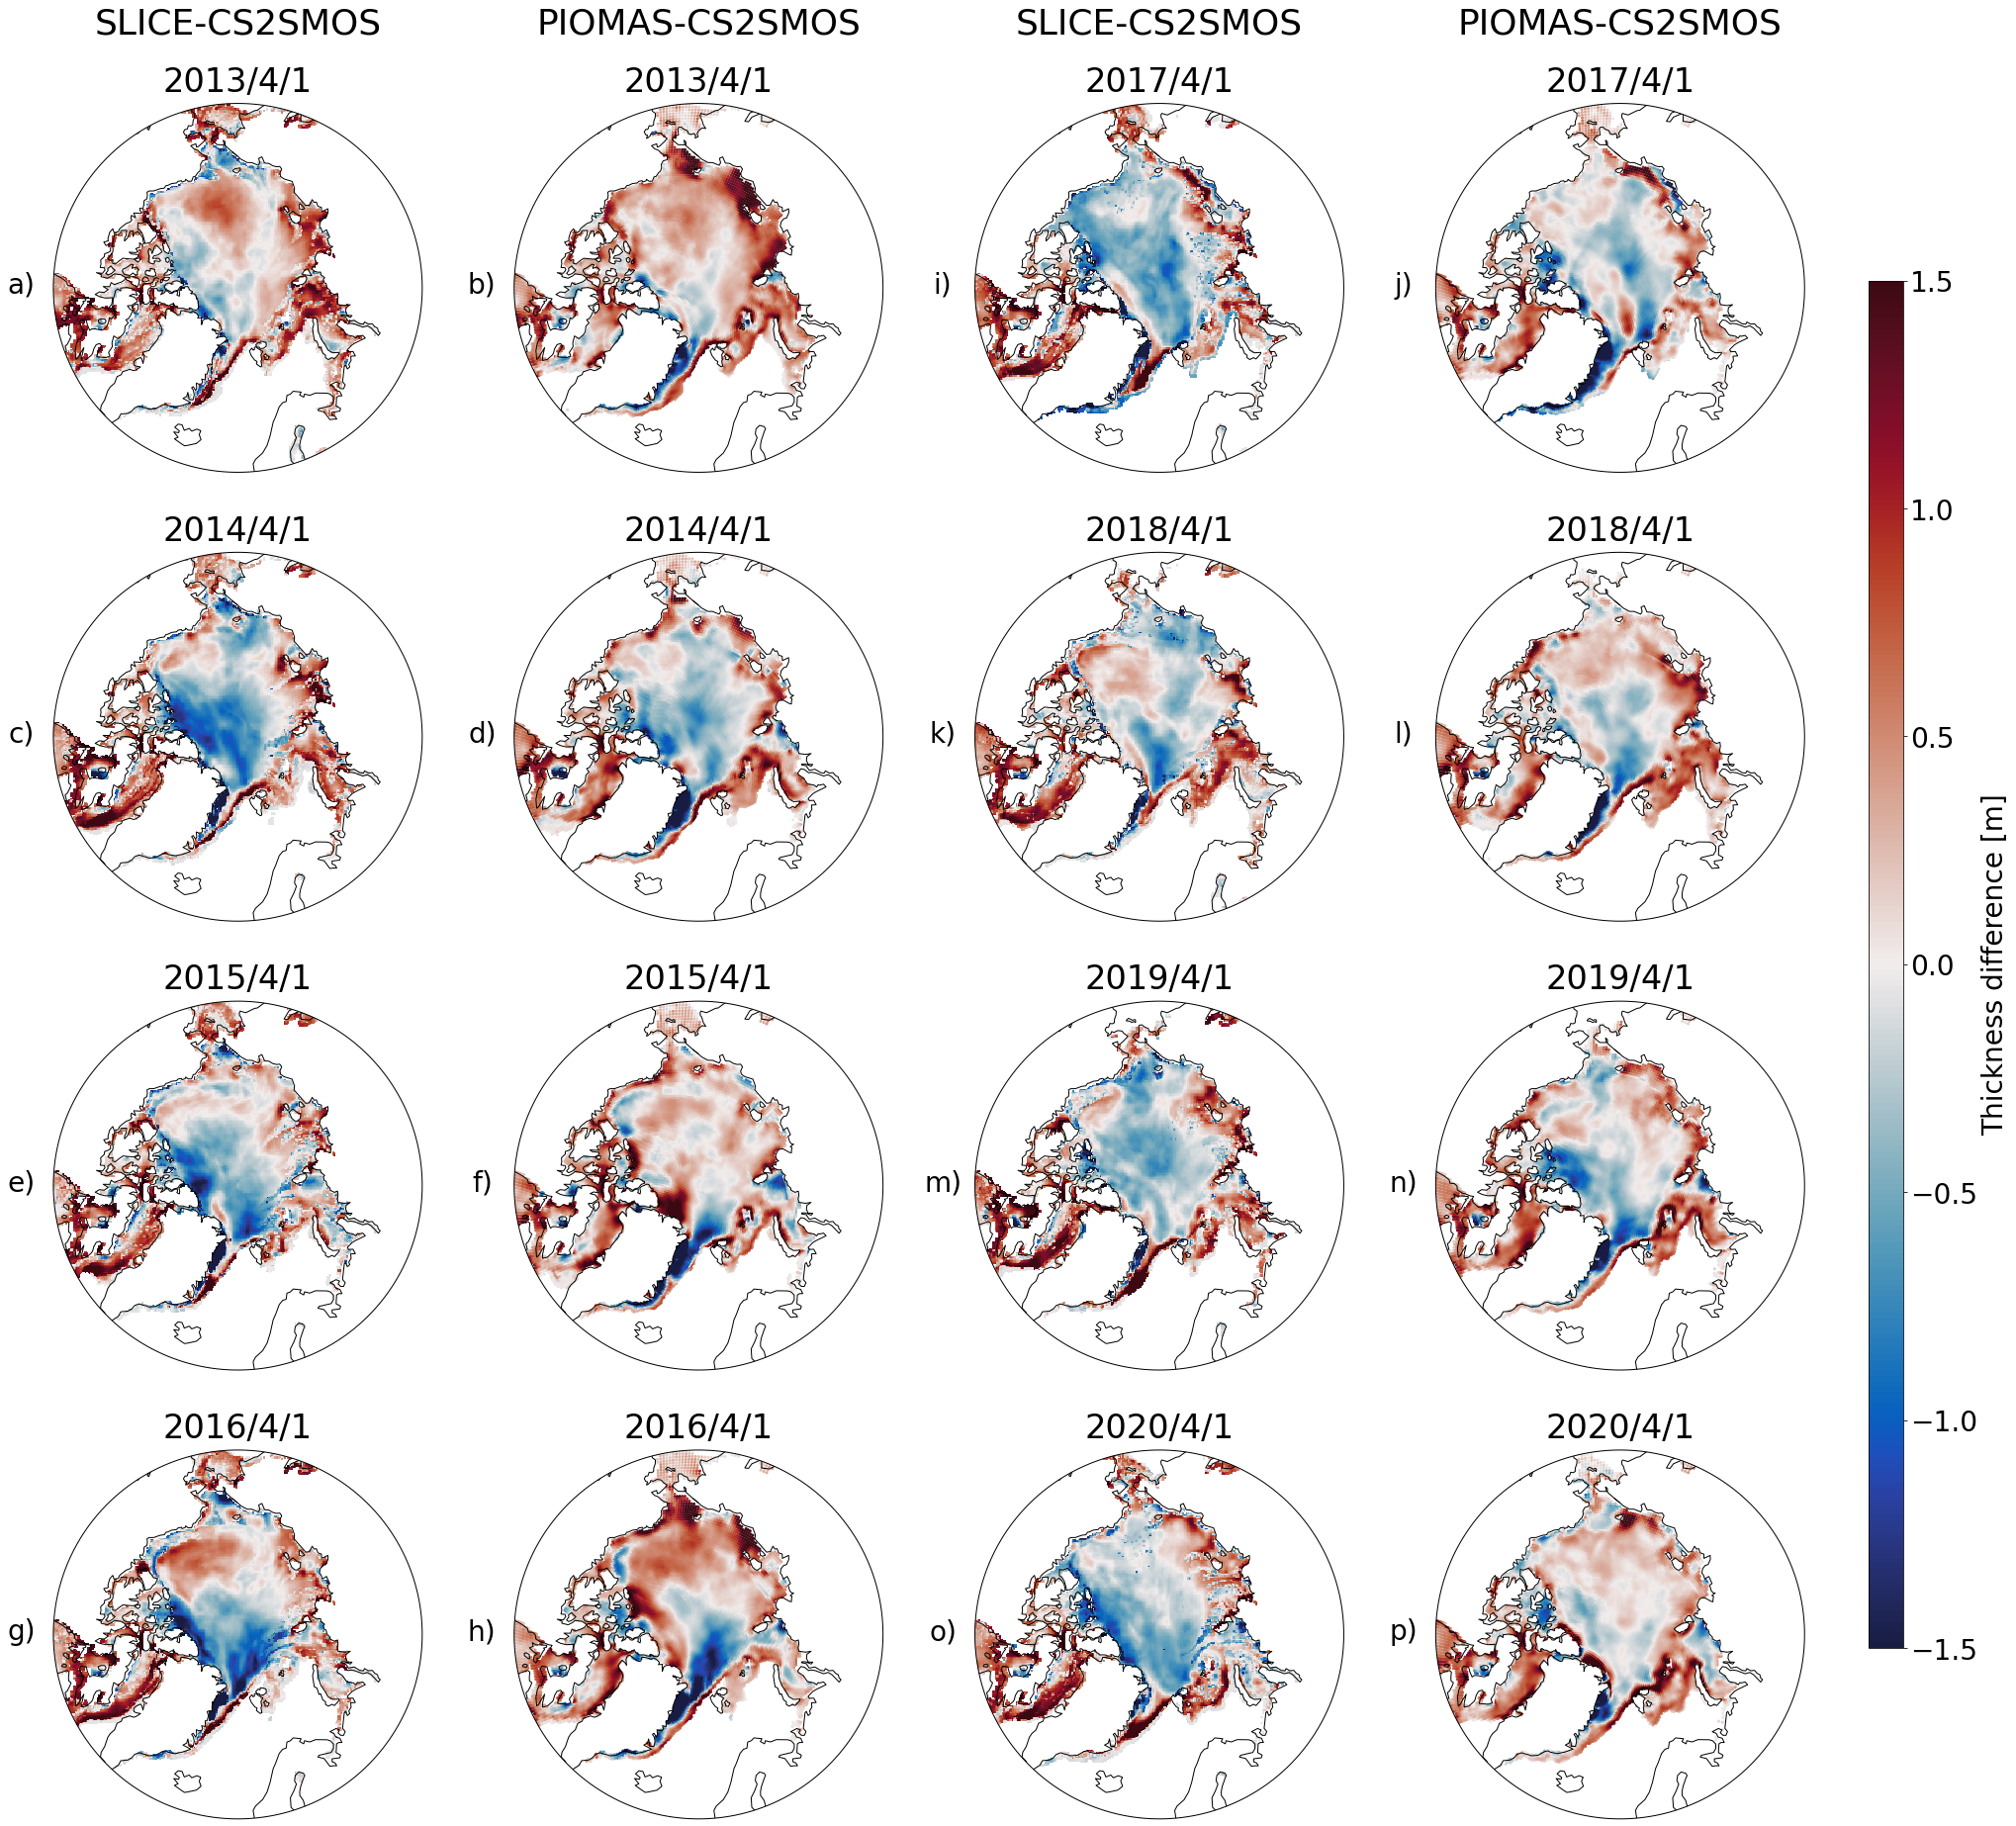

In [10]:
#Figure 7

fn=['2012_slice_basinwide.nc','2013_slice_basinwide.nc','2014_slice_basinwide.nc','2015_slice_basinwide.nc','2016_slice_basinwide.nc',
    '2017_slice_basinwide.nc','2018_slice_basinwide.nc','2019_slice_basinwide.nc'] 

slclist = {
  "cs": np.array([]),
  "slc": np.array([]),
}
piolist = {
  "cs": np.array([]),
  "pio": np.array([]),
}

labels=np.array(['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)','m)','n)','o)','p)']).reshape((8,2))

f, ax = plt.subplots(4, 4, subplot_kw={'projection': proj}, gridspec_kw={'width_ratios': [1, 1, 1, 1]})
f.set_figheight(32)
f.set_figwidth(32)

cstable = pd.DataFrame(np.zeros((len(fn),4)), columns=['slc_vol [km^3]', 'cs_vol [km^3]', 'init [km^3]', 'diff'], index=fn)
fnind=0
for j in [0,2]:
    for i in range(0,4):
        slc=xr.open_dataset(bwfp + fn[fnind]).sea_ice_thickness[-1,:,:]

        cs2fn = csfp + 'W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_'+str(slc.time.dt.year.values)+'0328*.nc'
        cs2fn = glob.glob(cs2fn)[0]
        cs2 = xr.open_dataset(cs2fn)
        cs2['analysis_sea_ice_thickness'] = cs2.analysis_sea_ice_thickness.where(cs2.analysis_sea_ice_thickness>0)
        cs2['xc']=cs2.xc*1000
        cs2['yc']=cs2.yc*1000
        cs2=cs2.rename({'xc': 'x','yc': 'y'})
        cs2=cs2.analysis_sea_ice_thickness[0,:,:]
        
        data = np.fromfile(piofp + 'hiday.H' + str(slc.time.dt.year.values), dtype='float32').reshape((365,43200))
        grid = np.genfromtxt(piofp + 'grid.dat')
        grid = np.reshape(grid,(grid.size))
        plon = grid[:grid.size//2]   
        plat = grid[grid.size//2:]

        px, py = transformer.transform(plat, plon)

        pio=data[slc.time.dt.dayofyear.values,:]
        pio[pio==0]=np.nan

        ax[i, 0+j].set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
        r_limit = ax[i, 0+j].get_ylim()
        circle_path = mpath.Path.unit_circle()
        circle_path = mpath.Path(circle_path.vertices.copy() * r_limit[0], circle_path.codes.copy())
        ax[i, 0+j].set_boundary(circle_path)
        ax[i, 0+j].set_frame_on(False)
        a = ax[i, 0+j].pcolormesh(cs2.x.values, cs2.y.values, (slc.sel(x=cs2.x,y=cs2.y)-cs2).values, 
                                  cmap=cmo.balance,vmin=-1.5,vmax=1.5)
        ax[i, 0+j].coastlines()
        ax[i, 0+j].set_title(str(int(fn[fnind][:4])+1) + '/4/1')
        ax[i, 0+j].text(-0.075, 0.5, labels[i+2*j, 0], transform=ax[i, 0+j].transAxes, va='center', ha='center')
        if i==0:
            ax[i, 0+j].text(0.5, 1.2, 'SLICE-CS2SMOS', transform=ax[i, 0+j].transAxes, va='center', ha='center', fontsize=36)

        
        ax[i, 1+j].set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
        r_limit = ax[i, 1+j].get_ylim()
        circle_path = mpath.Path.unit_circle()
        circle_path = mpath.Path(circle_path.vertices.copy() * r_limit[0], circle_path.codes.copy())
        ax[i, 1+j].set_boundary(circle_path)
        ax[i, 1+j].set_frame_on(False)
        b = ax[i, 1+j].scatter(px, py, 
                          c=pio-cs2.sel(x=xr.DataArray(px,dims=['z']),y=xr.DataArray(py,dims=['z']),method='nearest').values, 
                          cmap=cmo.balance,vmin=-1.5,vmax=1.5,s=4)
        ax[i, 1+j].coastlines()
        ax[i, 1+j].set_title(str(int(fn[fnind][:4])+1) + '/4/1')
        ax[i, 1+j].text(-0.075, 0.5, labels[i+2*j, 1], transform=ax[i, 1+j].transAxes, va='center', ha='center')
        if i==0:
            ax[i, 1+j].text(0.5, 1.2, 'PIOMAS-CS2SMOS', transform=ax[i, 1+j].transAxes, va='center', ha='center', fontsize=36)

        ind=np.isfinite(slc.sel(x=cs2.x,y=cs2.y).values.ravel()-cs2.values.ravel())
        slclist['slc']=np.append(slclist['slc'],slc.sel(x=cs2.x,y=cs2.y).values.ravel()[ind])
        slclist['cs']=np.append(slclist['cs'],cs2.values.ravel()[ind])
        
        ind=np.isfinite(pio-cs2.interp(x=xr.DataArray(px,dims=['z']),y=xr.DataArray(py,dims=['z']),method='linear').values)
        piolist['pio']=np.append(piolist['pio'],pio[ind])
        piolist['cs']=np.append(piolist['cs'],cs2.interp(x=xr.DataArray(px,dims=['z']),y=xr.DataArray(py,dims=['z']),method='linear').values[ind])
        
        fnind+=1

# for j in [0,3]:
#     cbab=f.colorbar(a, ax=ax[:,0+j].ravel().tolist(), shrink=0.6, aspect=30)
#     cbab.set_label('Ice Thickness [m]')

#     cbab=f.colorbar(b, ax=ax[:,1+j].ravel().tolist(), shrink=0.6, aspect=30)
#     cbab.set_label('Ice Thickness [m]')

cbar_ax = f.add_axes([0.925, 0.2, 0.015, 0.6])
cb=f.colorbar(b, cax=cbar_ax, label='Thickness difference [m]')

# ax[0,2].outline_patch.set_visible(False)
# ax[1,2].outline_patch.set_visible(False)
# ax[2,2].outline_patch.set_visible(False)
# ax[3,2].outline_patch.set_visible(False)

plt.savefig(outfp + 'diff.png', bbox_inches="tight")


/home/janheuser/.conda/envs/thk/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6931: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


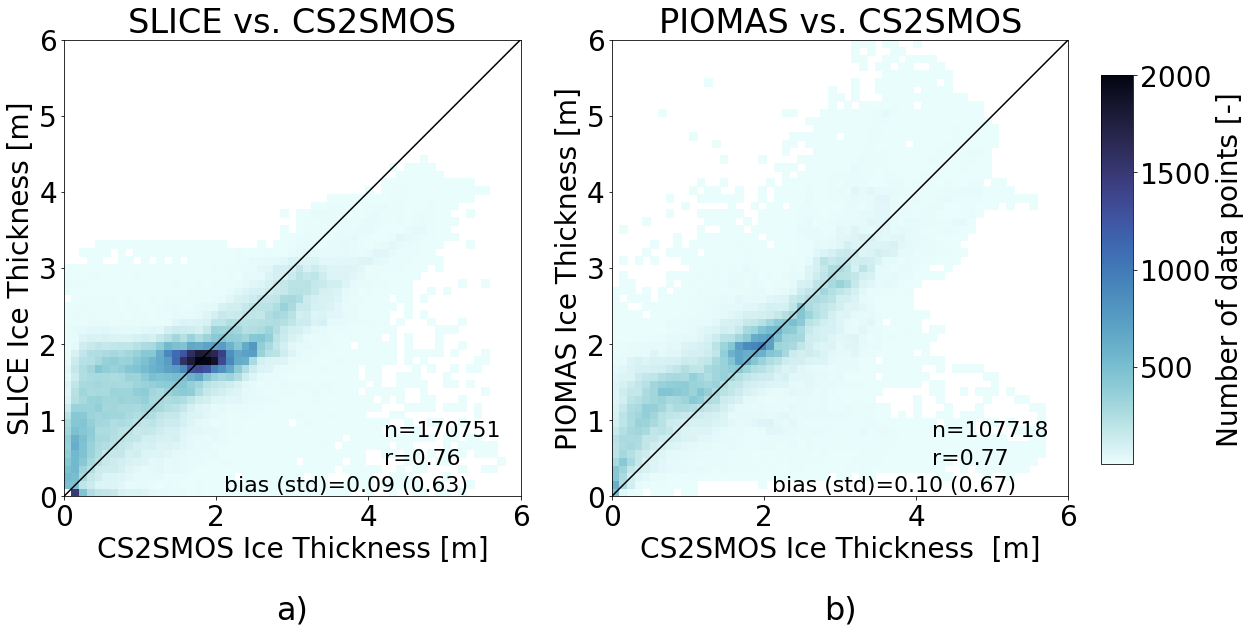

In [11]:
#Figure 8


f, ax = plt.subplots(1,2,figsize=(18, 9))
ax = ax.ravel()

d=ax[0].hist2d(slclist['cs'],slclist['slc'],bins=np.linspace(0,6,60),cmap=cmo.ice_r,cmin=0.5,cmax=2500,vmin=1,vmax=2000)
ax[0].set_xlim((0,6))
ax[0].set_ylim((0,6))
ax[0].plot((0,7),(0,7),'k')
ax[0].set(aspect='equal')
ax[0].set_title('SLICE vs. CS2SMOS')
ax[0].set_xlabel('CS2SMOS Ice Thickness [m]')
ax[0].set_ylabel('SLICE Ice Thickness [m]')
r=linregress(slclist['slc'],slclist['cs'])
b=np.mean(slclist['slc']-slclist['cs'])
s=np.std(slclist['slc']-slclist['cs'])
ax[0].text(0.7, 0.13, 'n=' + str(len(slclist['slc'])),transform=ax[0].transAxes, fontsize=22)
ax[0].text(0.35, 0.01, 'bias (std)=' + "{:.2f}".format(b) + ' (' + "{:.2f}".format(s) + ')' ,transform=ax[0].transAxes, fontsize=22)
ax[0].text(0.7, 0.07, 'r=' + "{:.2f}".format(r.rvalue) ,transform=ax[0].transAxes, fontsize=22)
ax[0].text(0.5, -0.25, 'a)', transform=ax[0].transAxes, fontsize=32, va='center', ha='center')

d=ax[1].hist2d(piolist['cs'],piolist['pio'],bins=np.linspace(0,6,60),cmap=cmo.ice_r,cmin=0.5,cmax=2500,vmin=1,vmax=2000)
ax[1].set_xlim((0,6))
ax[1].set_ylim((0,6))
ax[1].plot((0,7),(0,7),'k')
ax[1].set(aspect='equal')
ax[1].set_title('PIOMAS vs. CS2SMOS')
ax[1].set_xlabel('CS2SMOS Ice Thickness  [m]')
ax[1].set_ylabel('PIOMAS Ice Thickness [m]')
r=linregress(piolist['pio'],piolist['cs'])
b=np.mean(piolist['pio']-piolist['cs'])
s=np.std(piolist['pio']-piolist['cs'])
ax[1].text(0.7, 0.13, 'n=' + str(len(piolist['pio'])),transform=ax[1].transAxes, fontsize=22)
ax[1].text(0.35, 0.01, 'bias (std)=' + "{:.2f}".format(b) + ' (' + "{:.2f}".format(s) + ')' ,transform=ax[1].transAxes, fontsize=22)
ax[1].text(0.7, 0.07, 'r=' + "{:.2f}".format(r.rvalue) ,transform=ax[1].transAxes, fontsize=22)
ax[1].text(0.5, -0.25, 'b)', transform=ax[1].transAxes, fontsize=32, va='center', ha='center')

cbar_ax = f.add_axes([0.925, 0.2, 0.025, 0.6])
cb=f.colorbar(d[3],cax=cbar_ax, label='Number of data points [-]')

plt.savefig(outfp + 'cs2_comp.png', bbox_inches="tight")


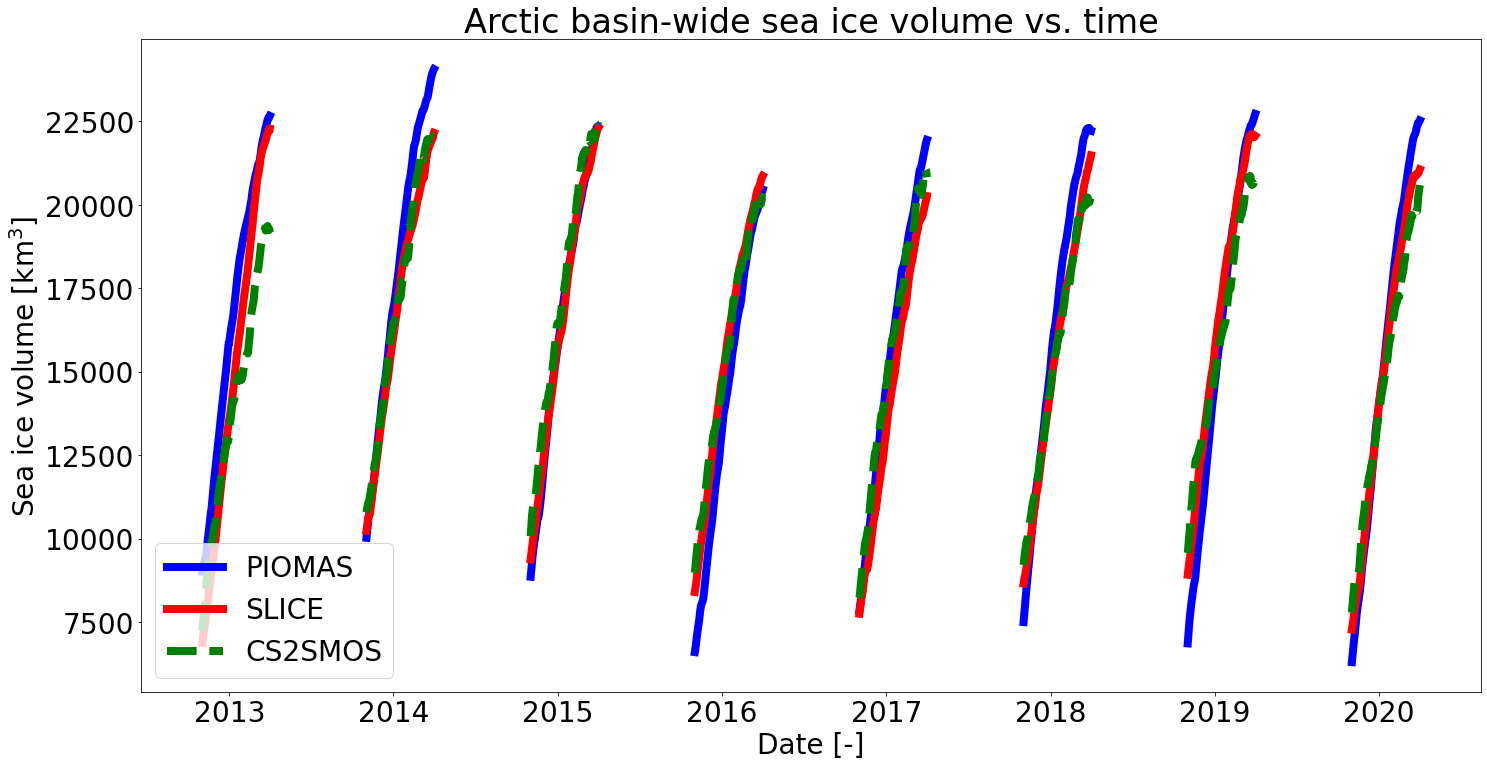

In [12]:
#Figure 9

time=pd.Index([])
for yr in range(2012,2020):
    time=time.append(pd.date_range(str(yr) + "-11-1", str(yr+1) + "-4-1"))

vols = xr.Dataset({
    'cs2': xr.DataArray(
                data   = np.zeros((len(time))),
                dims   = ['time'],
                coords = [time],
                ),
    'slc': xr.DataArray(
                data   = np.zeros((len(time))),
                dims   = ['time'],
                coords = [time],
                ),
    'pio': xr.DataArray(
                data   = np.zeros((len(time))),
                dims   = ['time'],
                coords = [time],
                ),
    }
)
vols['cs2'][:]=np.nan
vols['slc'][:]=np.nan
vols['pio'][:]=np.nan

pvol=np.loadtxt(piofp + 'PIOMAS.vol.daily.1979.2022.Current.v2.1.dat',skiprows=1)[:-90,2].reshape(43,365)

for t in range(0,len(time)):
        #slc
        slcyr=xr.open_dataset(bwfp+str((time[t]-pd.DateOffset(months=5)).year)+'_slice_basinwide_killic.nc')
        slc = slcyr.sea_ice_thickness.sel(time=time[t].strftime('%Y-%m-%d'))
        vols['slc'].loc[dict(time=time[t].date())]=np.nansum(25*25*slc.values.ravel()/1000)
        
        #cs2
        cs2fn=csfp + 'W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_'+(time[t]-pd.DateOffset(days=3)).strftime('%Y%m%d')+'*.nc'
        cs2fn = glob.glob(cs2fn)[0]
        cs2 = xr.open_dataset(cs2fn)
        vols['cs2'].loc[dict(time=time[t].date())]=np.nansum(25*25*(cs2.analysis_sea_ice_thickness[0,:,:].values.ravel())/1000)

        #piomas
        if time[t].dayofyear!=366:
            vols['pio'].loc[dict(time=time[t].date())]=pvol[time[t].year-1978,time[t].dayofyear-1]*1000

f, ax = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(24)

ax.set_title('Arctic basin-wide sea ice volume vs. time')
ax.set_ylabel('Sea ice volume [km$^3$]')
ax.set_xlabel('Date [-]')

plt.plot(vols.time.values,vols.pio.where(np.append(0,vols.time.diff(dim='time').dt.days<=1)).values, 'b', label='PIOMAS', linewidth=lw)
plt.plot(vols.time.values,vols.slc.where(np.append(0,vols.time.diff(dim='time').dt.days<=1)).values, 'r', label='SLICE', linewidth=lw)
plt.plot(vols.time.values,vols.cs2.where(np.append(0,vols.time.diff(dim='time').dt.days<=1)).values, 'g--', label='CS2SMOS', linewidth=lw)

plt.legend(loc='lower left')

plt.savefig(outfp + 'vol_timeseries.png', bbox_inches="tight")

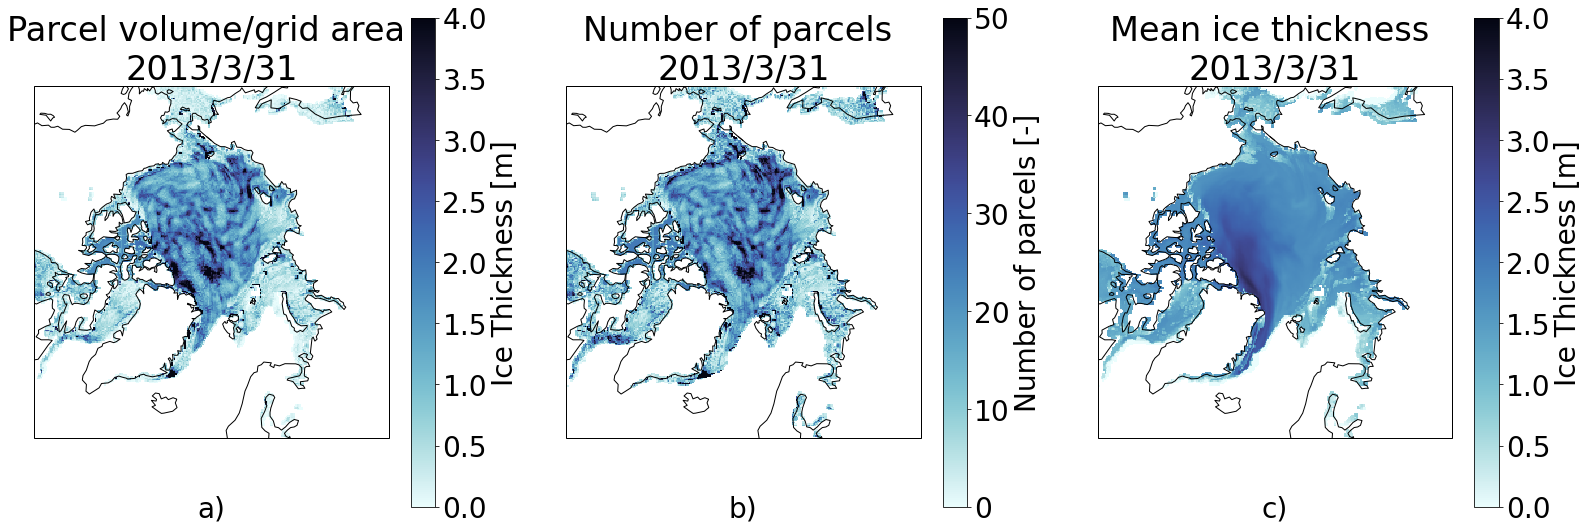

In [15]:
#Figure A1

parcels=xr.open_dataset(bwfp + 'a1.nc').analysis_sea_ice_thickness
proj=ccrs.Stereographic(central_longitude=0, central_latitude=90)
ease=xr.open_dataset('../../EASE2_N25km.geolocation.v0.9.nc')
ease['y']=-ease.y

s = binned_statistic_2d(parcels.y[-1,:].where(~np.isnan(parcels[-1,:]), drop=True).values, 
                        parcels.x[-1,:].where(~np.isnan(parcels[-1,:]), drop=True).values, 
                        parcels[-1,:].where(~np.isnan(parcels[-1,:]), drop=True).values, 'sum', 
                        bins=[ease.y.values, ease.x.values]).statistic/25
s[s==0]=np.nan

c = binned_statistic_2d(parcels.y[-1,:].where(~np.isnan(parcels[-1,:]), drop=True).values, 
                        parcels.x[-1,:].where(~np.isnan(parcels[-1,:]), drop=True).values, 
                        parcels[-1,:].where(~np.isnan(parcels[-1,:]), drop=True).values, 'count', 
                        bins=[ease.y.values, ease.x.values]).statistic
c[c==0]=np.nan

m = binned_statistic_2d(parcels.y[-1,:].where(~np.isnan(parcels[-1,:]), drop=True).values, 
                        parcels.x[-1,:].where(~np.isnan(parcels[-1,:]), drop=True).values, 
                        parcels[-1,:].where(~np.isnan(parcels[-1,:]), drop=True).values, 'mean', 
                        bins=[ease.y.values, ease.x.values]).statistic

f, ax = plt.subplots(1, 3, subplot_kw={'projection': proj})
ax = ax.ravel()
f.set_figheight(9)
f.set_figwidth(27)

a = ax[0].pcolormesh(ease.x.values, ease.y.values, s,vmin=0,vmax=4,cmap=cmo.ice_r)
ax[0].set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
ax[0].coastlines()
ax[0].set_title('Parcel volume/grid area \n2013/3/31')
cb = plt.colorbar(a, ax=ax[0])
cb.set_label('Ice Thickness [m]')
ax[0].text(0.5, -0.2, 'a)', transform=ax[0].transAxes, va='center', ha='center')

a = ax[1].pcolormesh(ease.x.values, ease.y.values, c,vmin=0,vmax=50,cmap=cmo.ice_r)
ax[1].set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
ax[1].coastlines()
ax[1].set_title('Number of parcels \n2013/3/31')
cb = plt.colorbar(a, ax=ax[1])
cb.set_label('Number of parcels [-]')
ax[1].text(0.5, -0.2, 'b)', transform=ax[1].transAxes, va='center', ha='center')

b = ax[2].pcolormesh(ease.x.values, ease.y.values, m,vmin=0,vmax=4,cmap=cmo.ice_r)
ax[2].set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
ax[2].coastlines()
ax[2].set_title('Mean ice thickness \n2013/3/31')
cb = plt.colorbar(b)
cb.set_label('Ice Thickness [m]')
ax[2].text(0.5, -0.2, 'c)', transform=ax[2].transAxes, va='center', ha='center')

plt.savefig(outfp + 'sum.png', bbox_inches="tight")


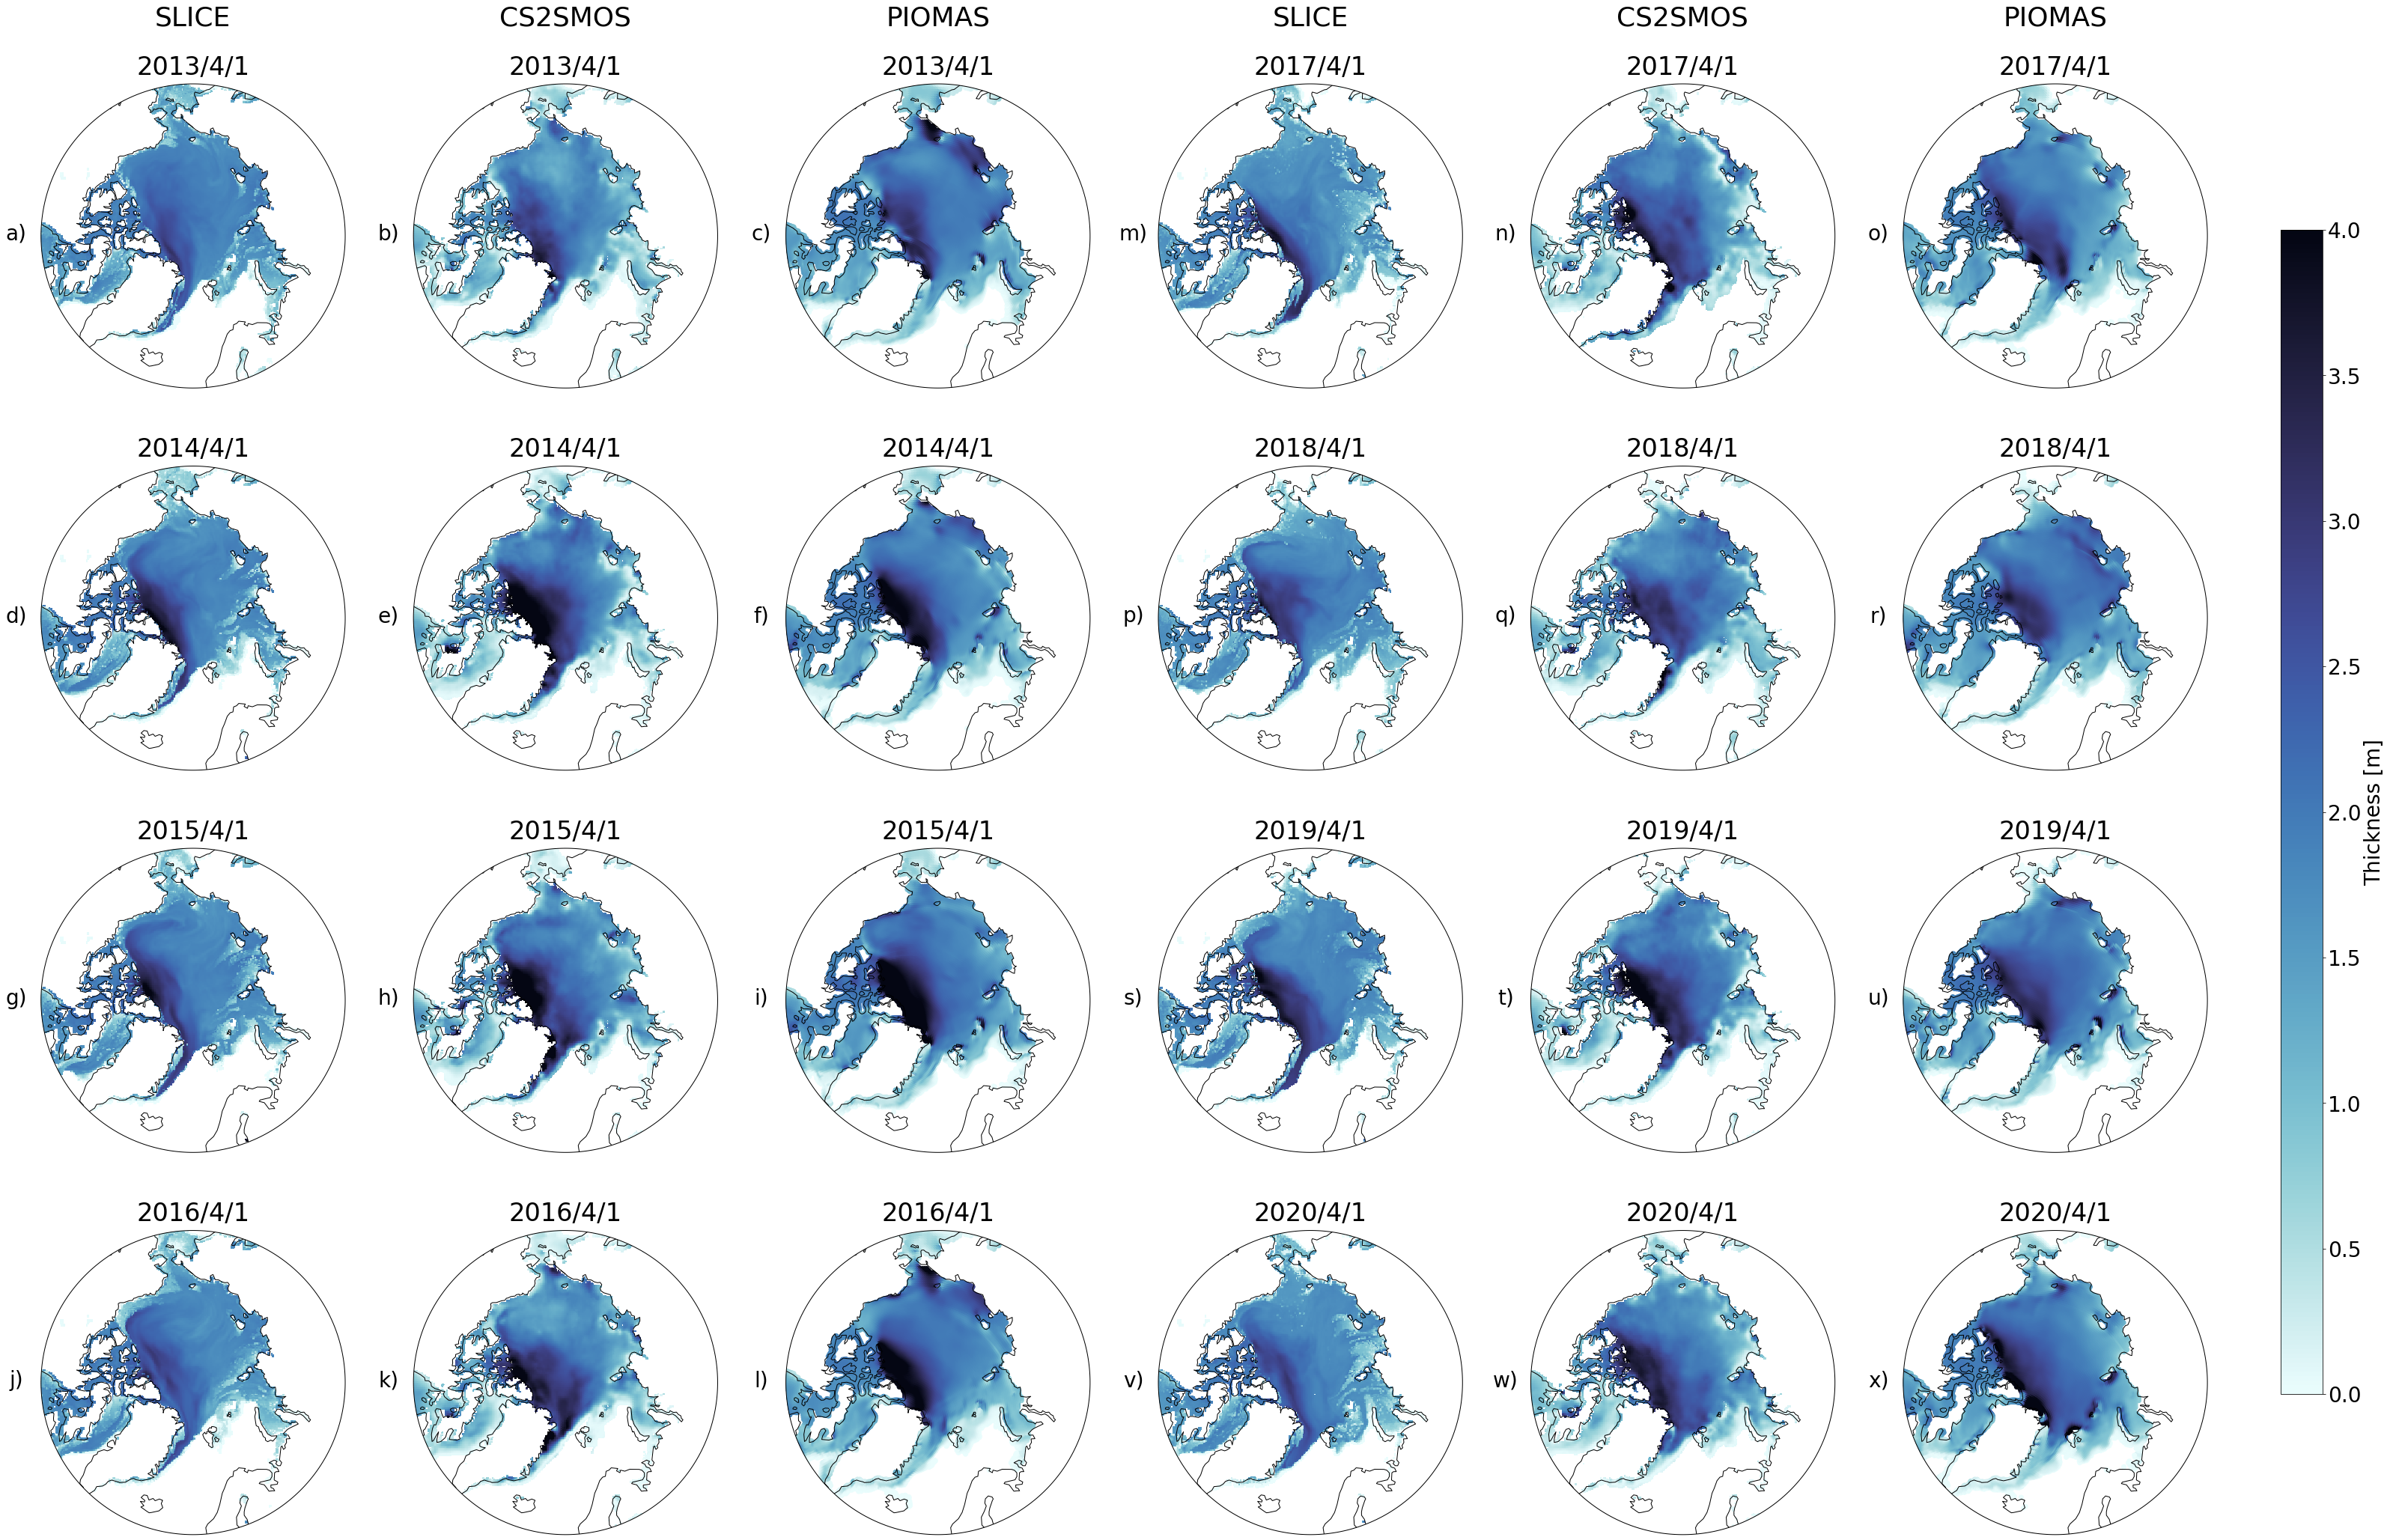

In [13]:
#Figure A2

fn=['2012_slice_basinwide.nc','2013_slice_basinwide.nc','2014_slice_basinwide.nc','2015_slice_basinwide.nc','2016_slice_basinwide.nc',
    '2017_slice_basinwide.nc','2018_slice_basinwide.nc','2019_slice_basinwide.nc']

cslist=np.array([])
slclist=np.array([])

labels=np.array(['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)','m)','n)','o)','p)','q)','r)','s)','t)',
                     'u)','v)','w)','x)'])
labels=np.hstack([labels[:12].reshape((4,3)),labels[12:].reshape((4,3))])

f, ax = plt.subplots(4, 6, subplot_kw={'projection': proj}, gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1]})
f.set_figheight(36)
f.set_figwidth(52)

for j in [0,3]:
    for i in range(0,4):
        slc=xr.open_dataset(bwfp+fn[i+int(j+1/3*j)]).sea_ice_thickness[-1,:,:]#-xr.open_dataset(bwfp+fn2[i+j]).sea_ice_thickness[-1,:,:]
        
        data = np.fromfile(piofp + 'hiday.H' + str(slc.time.dt.year.values), dtype='float32').reshape((365,43200))
        grid = np.genfromtxt(piofp + 'grid.dat')
        grid = np.reshape(grid,(grid.size))
        plon = grid[:grid.size//2]   
        plat = grid[grid.size//2:]

        transformer = Transformer.from_crs(4326, 6931)
        px, py = transformer.transform(plat, plon)
        pio=data[slc.time.dt.dayofyear.values,:]
        pio[pio==0]=np.nan

        cs2fn=csfp + 'W_XX-ESA,SMOS_CS2,NH_25KM_EASE2_'+str(slc.time.dt.year.values)+'0329*.nc'
        cs2fn = glob.glob(cs2fn)[0]
        cs2 = xr.open_dataset(cs2fn)
        cs2['analysis_sea_ice_thickness'] = cs2.analysis_sea_ice_thickness.where(cs2.analysis_sea_ice_thickness>0)
        cs2['xc']=cs2.xc*1000
        cs2['yc']=cs2.yc*1000
        cs2=cs2.rename({'xc': 'x','yc': 'y'})
        cs2=cs2.analysis_sea_ice_thickness[0,:,:]

        ax[i, 0+j].set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
        r_limit = ax[i, 0+j].get_ylim()
        circle_path = mpath.Path.unit_circle()
        circle_path = mpath.Path(circle_path.vertices.copy() * r_limit[0], circle_path.codes.copy())
        ax[i, 0+j].set_boundary(circle_path)
        ax[i, 0+j].set_frame_on(False)
        a = ax[i, 0+j].pcolormesh(slc.x.values, slc.y.values, 
                                slc.values, 
                                cmap=cmo.ice_r,vmin=0,vmax=4)
        ax[i, 0+j].coastlines()
        ax[i, 0+j].set_title(str(int(fn[i+int(j+1/3*j)][:4])+1) + '/4/1')
        ax[i, 0+j].text( -0.07, 0.5, labels[i, 0+j], transform=ax[i, 0+j].transAxes, va='center', ha='center')
        if i==0:
            ax[i, 0+j].text(0.5, 1.2, 'SLICE', transform=ax[i, 0+j].transAxes, va='center', ha='center', fontsize=36)

        
        ax[i, 2+j].set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
        r_limit = ax[i, 2+j].get_ylim()
        circle_path = mpath.Path.unit_circle()
        circle_path = mpath.Path(circle_path.vertices.copy() * r_limit[0], circle_path.codes.copy())
        ax[i, 2+j].set_boundary(circle_path)
        ax[i, 2+j].set_frame_on(False)
        b = ax[i, 2+j].scatter(px, py, 
                                c=pio, 
                                cmap=cmo.ice_r,vmin=0,vmax=4)
        ax[i, 2+j].coastlines()
        ax[i, 2+j].set_title(str(int(fn[i+int(j+1/3*j)][:4])+1) + '/4/1')
        ax[i, 2+j].text(-0.07, 0.5, labels[i, 1+j], transform=ax[i, 1+j].transAxes, va='center', ha='center')
        if i==0:
            ax[i, 2+j].text(0.5, 1.2, 'PIOMAS', transform=ax[i, 2+j].transAxes, va='center', ha='center', fontsize=36)

        ax[i, 1+j].set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
        r_limit = ax[i, 1+j].get_ylim()
        circle_path = mpath.Path.unit_circle()
        circle_path = mpath.Path(circle_path.vertices.copy() * r_limit[0], circle_path.codes.copy())
        ax[i, 1+j].set_boundary(circle_path)
        ax[i, 1+j].set_frame_on(False)
        c = ax[i, 1+j].pcolormesh(cs2.x.values, cs2.y.values, 
                          cs2.values, 
                          cmap=cmo.ice_r,vmin=0,vmax=4)
        ax[i, 1+j].coastlines()
        ax[i, 1+j].set_title(str(int(fn[i+int(j+1/3*j)][:4])+1) + '/4/1')
        ax[i, 1+j].text(-0.07, 0.5, labels[i, 2+j], transform=ax[i, 2+j].transAxes, va='center', ha='center')
        if i==0:
            ax[i, 1+j].text(0.5, 1.2, 'CS2SMOS', transform=ax[i, 1+j].transAxes, va='center', ha='center', fontsize=36)


# for j in [0,4]:
#     cbab=f.colorbar(a, ax=ax[:,0+j].ravel().tolist(), shrink=0.6, aspect=30)
#     cbab.set_label('Ice Thickness [m]')

#     cbab=f.colorbar(b, ax=ax[:,1+j].ravel().tolist(), shrink=0.6, aspect=30)
#     cbab.set_label('Ice Thickness [m]')

#     cbab=f.colorbar(c, ax=ax[:,2+j].ravel().tolist(), shrink=0.6, aspect=30)
#     cbab.set_label('Ice Thickness [m]')

# ax[0,3].outline_patch.set_visible(False)
# ax[1,3].outline_patch.set_visible(False)
# ax[2,3].outline_patch.set_visible(False)
# ax[3,3].outline_patch.set_visible(False)

cbar_ax = f.add_axes([0.925, 0.2, 0.015, 0.6])
cb=f.colorbar(c, cax=cbar_ax, label='Thickness [m]')

plt.savefig(outfp + 'end_vol.png', bbox_inches="tight")
